# Phillipsite ternary diagrams

[Sean Mulcahy](mailto:sean.mulcahy@wwu.edu), [Western Washington University](https://wp.wwu.edu/mulcahy)

This notebook is used to create Figures 3 and 4 in Jackson et al., 2017.  The code below does the following:
* calculate phillipsite formulas based on 16O  
* propagate the 2-sigma standard deviation on the weight% oxide using the [Uncertainties](https://pythonhosted.org/uncertainties/numpy_guide.html) package
* plot phillipsite ternary diagrams using the [python-ternary](https://github.com/marcharper/python-ternary) package
* final publication figures were formatted in Adobe Illustrator

## Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
from uncertainties import unumpy
import ternary 
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style='ticks')
%matplotlib inline

/Users/sean/miniconda3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Import the data

Import the EPMA phillipsite analyses and 2-sigma uncertainties on the weight% oxides.

In [2]:
# Weight percent oxides
df = pd.read_csv("../data/phillipsite-oxide.csv", index_col='Sample')

# 1-sigma absolute error from counting statistics
sigma = pd.read_csv("../data/phillipsite-oxide-2sigma.csv", index_col='Sample')

## Create Uncertainty array and convert to Pandas data.frame

In [3]:
# Combine oxides and error into uncertainty array
ox = unumpy.uarray(df.values, sigma.values)

# Create pandas data.frame
oxides = pd.DataFrame(ox, index=df.index)

# Name columns with oxides
oxides.columns=list(df.columns.values)

# Show the data.frame
oxides.head()

,SiO2,TiO2,Al2O3,Cr2O3,Fe2O3,MnO,MgO,CaO,Na2O,K2O
Sample,,,,,,,,,,
05-BRI BT Pum 3,56.5+/-0.5,0.43+/-0.27,17.87+/-0.22,0.0+/-0,0.0+/-0,0.0+/-0,0.033+/-0.025,2.27+/-0.14,2.28+/-0.12,8.89+/-0.28
05-BRI BT Pum 3,56.4+/-0.5,0.0+/-0,20.08+/-0.23,0.0+/-0,0.0+/-0,0.0+/-0,0.095+/-0.027,2.07+/-0.14,1.30+/-0.09,5.54+/-0.23
05-BRI BT Pum 3,54.4+/-0.5,0.0+/-0,18.05+/-0.22,0.0+/-0,0.21+/-0.21,0.0+/-0,0.043+/-0.028,1.80+/-0.13,2.32+/-0.12,8.48+/-0.28
05-BRI BT Pum 3,53.3+/-0.5,0.0+/-0,17.43+/-0.22,0.0+/-0,0.0+/-0,0.0+/-0,0.103+/-0.030,2.14+/-0.14,1.64+/-0.10,7.48+/-0.26
05-BRI BT Pum 3,59.9+/-0.5,0.0+/-0,20.85+/-0.24,0.0+/-0,0.0+/-0,0.0+/-0,0.111+/-0.028,1.96+/-0.13,3.24+/-0.14,8.02+/-0.27


## Calculate cations and uncertainties

This method, using the [Uncertainties](https://pythonhosted.org/uncertainties/numpy_guide.html) package, accurately reproduces the results of [Giaramita and Day, 1990](http://www.minsocam.org/ammin/AM75/AM75_170.pdf) using partial error propagation.  

In [4]:
# Cations per oxide
cpo = [1., 1., 2., 2., 2., 1., 1., 1., 2., 2.]

# Anions per oxides
apo = [2., 2., 3., 3., 3., 1., 1., 1., 1., 1.]

# Atomic weight of the oxides
awo = [60.08, 79.88, 101.96, 151.99, 159.69, 70.94, 40.30, 56.08, 61.98, 94.20]

# Define functions
def fcat(x):
    return (x / awo) * cpo

def fox(x):
    return (x / awo) * apo

def f(x):
    return (x * ofact)

# Calculate cations
cat = oxides.apply(fcat, axis = 1)
ox = oxides.apply(fox, axis = 1)
osum = ox.apply(sum, axis=1)

# Oxygen basis
ofact = 16./osum
cations = cat.apply(f)


# Sum each analysis (row)
CatSum = cations.apply(sum, axis=1)
cations.loc[:,'Total'] = CatSum

# Label the columns
cations.columns = ['Si', 'Ti', 'Al', 'Cr', 'Fe3', 'Mn', 'Mg', 'Ca', 'Na', 'K', 'Total']
cations.index = df.index

## Save the results to separate Pandas data.frames

In [5]:
# Cation formula units
cation_formula = pd.DataFrame(unumpy.nominal_values(cations))
cation_formula.columns =  ['Si', 'Ti', 'Al', 'Cr', 'Fe3', 'Mn', 'Mg', 'Ca', 'Na', 'K', 'Total']
cation_formula.index = df.index
cation_formula.to_csv("../data/phillipsite-cation.csv")

# Errors on cation formula units
cation_sigma = pd.DataFrame(unumpy.std_devs(cations))
cation_sigma.columns =  ['sSi', 'sTi', 'sAl', 'sCr', 'sFe3', 'sMn', 'sMg', 'sCa', 'sNa', 'sK', 'sTotal']
cation_sigma.index = df.index
cation_sigma.to_csv("../data/phillipsite-cation-error.csv")

## (Ca+Mg)-Na-K ternary for analyzed samples

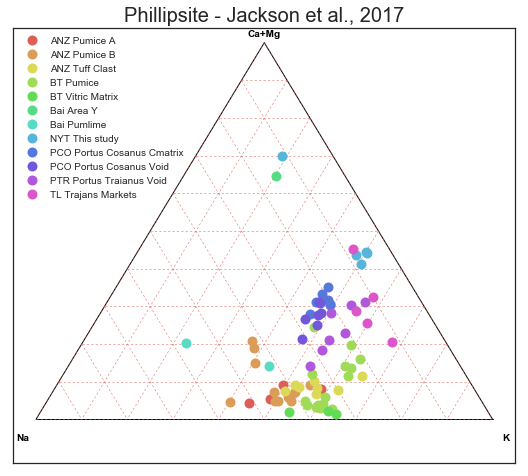

In [6]:
# Group points by sample
df = pd.read_csv('../data/phillipsite-cations-plotting.csv')
groups=df.groupby('PlotGroup')

# Set up ternary plot
sns.set_palette("hls", 13)
figure, tax = ternary.figure(scale=100.0)
tax.boundary(linewidth=1.0)
tax.gridlines(multiple=10) 

# Plot points by sample
for name, group in groups:
    tCM = (group.Ca+group.Mg)/(group.Ca+group.Mg+group.Na+group.K)
    tN = group.Na/(group.Ca+group.Mg+group.Na+group.K)
    tK = group.K/(group.Ca+group.Mg+group.Na+group.K)
    cmnk = 100*np.column_stack((tK, tCM, tN))
    #np.savetxt(('../data/phillipsite-ternary/'+str(name)+'.csv'), cmnk, delimiter=',')
    tax.plot(cmnk, linestyle='', marker='o', ms=10, label=name)

# Set Axis labels and Title
fontsize = 20
tax.set_title('Phillipsite - Jackson et al., 2017', fontsize=fontsize)

plt.text(-3, -5, 'Na', color='black', ha='center', fontweight='bold')
plt.text(103, -5, 'K', color='black', ha='center', fontweight='bold')
plt.text(50, 88, 'Ca+Mg', color='black', ha='center', fontweight='bold')
    
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.legend(loc=2)

# Size figure
figure.set_figheight(8)
figure.set_figwidth(9)

plt.savefig('../figs/phillipsite-CMNK-jacksonetal.svg')

## (Ca+Mg)-Na-K ternary for previously published samples

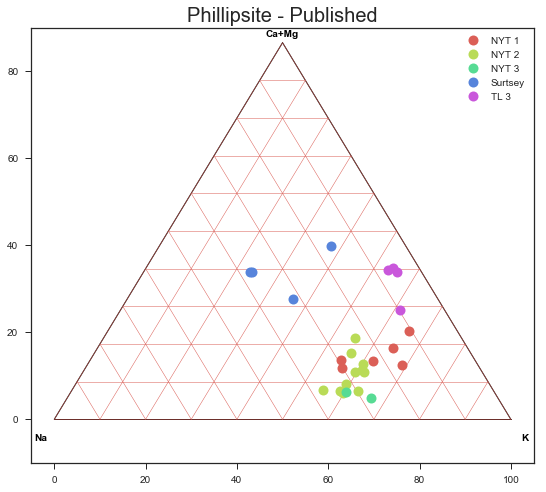

In [7]:
oxides = pd.read_csv('../data/philipsite-oxides-literature.csv', index_col='PlotGroup')

# Cations per oxide
cpo = [1., 1., 2., 2., 2., 1., 1., 1., 2., 2.]

# Anions per oxides
apo = [2., 2., 3., 3., 3., 1., 1., 1., 1., 1.]

# Atomic weight of the oxides
awo = [60.08, 79.88, 101.96, 151.99, 159.69, 70.94, 40.30, 56.08, 61.98, 94.20]

# Define functions
def fcat(x):
    return (x / awo) * cpo

def fox(x):
    return (x / awo) * apo

def f(x):
    return (x * ofact)

# Calculate cations
cat = oxides.apply(fcat, axis = 1)

# Calculate cations
cat = oxides.apply(fcat, axis = 1)
ox = oxides.apply(fox, axis = 1)
osum = ox.apply(sum, axis=1)

# Oxygen basis
ofact = 16./osum
cations = cat.apply(f)


# Sum each analysis (row)
CatSum = cations.apply(sum, axis=1)
cations.loc[:,'Total'] = CatSum

# Label the columns
cations.columns = ['Si', 'Ti', 'Al', 'Cr', 'Fe3', 'Mn', 'Mg', 'Ca', 'Na', 'K', 'Total']
cations=cations.reset_index()
#cations.to_csv('/Users/sean/Desktop/phil-litcat.csv')

groups=cations.groupby('PlotGroup')

# Set up ternary plot
sns.set_palette("hls", 5)
figure, tax = ternary.figure(scale=100.0)
tax.boundary(linewidth=1.0)
tax.gridlines(linestyle="-", multiple=10) 

# Plot points by sample
for name, group in groups:
    tCM = (group.Ca+group.Mg)/(group.Ca+group.Mg+group.Na+group.K)
    tN = group.Na/(group.Ca+group.Mg+group.Na+group.K)
    tK = group.K/(group.Ca+group.Mg+group.Na+group.K)
    cmnk = 100*np.column_stack((tK, tCM, tN))
    #np.savetxt(('../data/phillipsite-ternary/'+str(name)+'.csv'), cmnk, delimiter=',')
    tax.plot(cmnk, linestyle='', marker='o', ms=10, label=name)

# Set Axis labels and Title
fontsize = 20
tax.set_title('Phillipsite - Published', fontsize=fontsize)

plt.text(-3, -5, 'Na', color='black', ha='center', fontweight='bold')
plt.text(103, -5, 'K', color='black', ha='center', fontweight='bold')
plt.text(50, 88, 'Ca+Mg', color='black', ha='center', fontweight='bold')
     
# Remove default Matplotlib Axes
#tax.clear_matplotlib_ticks()
tax.legend()

# Size figure
figure.set_figheight(8)
figure.set_figwidth(9)

plt.savefig('../figs/phillipsite-CMNK-published.svg')

## S-D-M ternary for analyzed samples

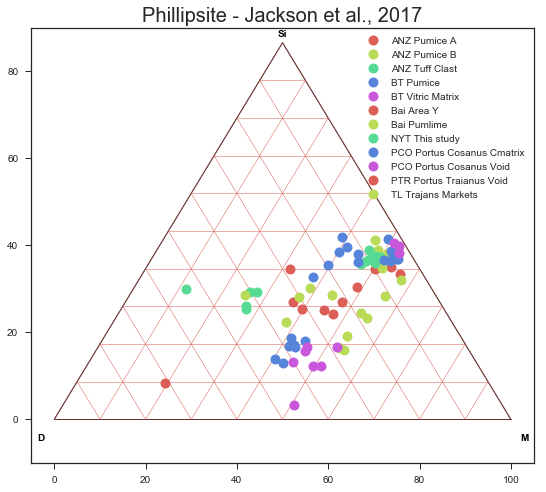

In [8]:
df = pd.read_csv('../data/phillipsite-cations-plotting.csv')

s = df.Si - df.Al
d = (2*(2*(df.Ca+df.Mg)*df.Al))/((df.Na+df.K)+2*(df.Ca+df.Mg))
m = (2*((df.Na+df.K)*df.Al))/((df.Na+df.K)+2*(df.Ca+df.Mg))

t = s + d + m

df['S'] = s/t
df['D'] = d/t
df['M'] = m/t

groups=df.groupby('PlotGroup')

# Set up ternary plot
sns.set_palette("hls", 5)
figure, tax = ternary.figure(scale=100.0)
tax.boundary(linewidth=1.0)
tax.gridlines(linestyle="-", multiple=10) 

# Plot points by sample
for name, group in groups:
    s = group.S
    d = group.D
    m = group.M
    sdm = 100*np.column_stack((m, s, d))
    #np.savetxt(('../data/phillipsite2-ternary/'+str(name)+'.csv'), cmnk, delimiter=',')
    tax.plot(sdm, linestyle='', marker='o', ms=10, label=name)


# Set Axis labels and Title
fontsize = 20
tax.set_title('Phillipsite - Jackson et al., 2017', fontsize=fontsize)

plt.text(-3, -5, 'D', color='black', ha='center', fontweight='bold')
plt.text(103, -5, 'M', color='black', ha='center', fontweight='bold')
plt.text(50, 88, 'Si', color='black', ha='center', fontweight='bold') 
    
# Remove default Matplotlib Axes
#tax.clear_matplotlib_ticks()
tax.legend()

# Size figure
figure.set_figheight(8)
figure.set_figwidth(9)

plt.savefig('../figs/phillipsite-SDM-jacksonetal.svg')

## S-D-M ternary for previously published samples

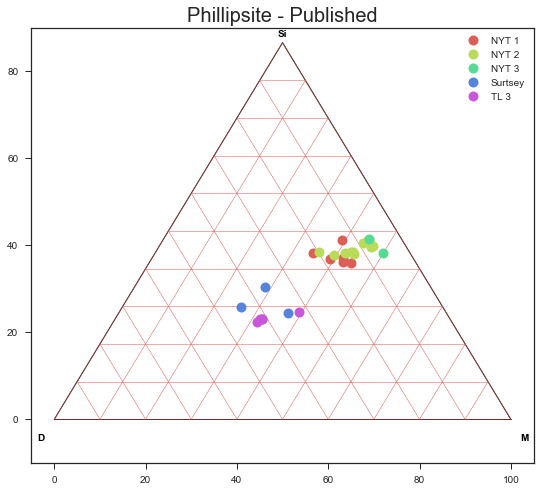

In [9]:
s = cations.Si - cations.Al
d = (2*(2*(cations.Ca+cations.Mg)*cations.Al))/((cations.Na+cations.K)+2*(cations.Ca+cations.Mg))
m = (2*((cations.Na+cations.K)*cations.Al))/((cations.Na+cations.K)+2*(cations.Ca+cations.Mg))
t = s + d + m

cations['S'] = s/t
cations['D'] = d/t
cations['M'] = m/t

groups=cations.groupby('PlotGroup')

# Set up ternary plot
sns.set_palette("hls", 5)
figure, tax = ternary.figure(scale=100.0)
tax.boundary(linewidth=1.0)
tax.gridlines(linestyle="-", multiple=10) 

# Plot points by sample
for name, group in groups:
    s = group.S
    d = group.D
    m = group.M
    sdm = 100*np.column_stack((m, s, d))
    #np.savetxt(('../data/phillipsite2-ternary/'+str(name)+'.csv'), cmnk, delimiter=',')
    tax.plot(sdm, linestyle='', marker='o', ms=10, label=name)


# Set Axis labels and Title
fontsize = 20
tax.set_title('Phillipsite - Published', fontsize=fontsize)

plt.text(-3, -5, 'D', color='black', ha='center', fontweight='bold')
plt.text(103, -5, 'M', color='black', ha='center', fontweight='bold')
plt.text(50, 88, 'Si', color='black', ha='center', fontweight='bold')
    
# Remove default Matplotlib Axes
#tax.clear_matplotlib_ticks()
tax.legend()

# Size figure
figure.set_figheight(8)
figure.set_figwidth(9)

plt.savefig('../figs/phillipsite-SDM-published.svg')